In [118]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from mongo_wrapper.mongo_wrapper import MongoWrapper

import os
from dotenv import load_dotenv

In [119]:
load_dotenv()

True

In [120]:
MONGO_IP = os.getenv("MONGO_IP")
MONGO_PORT = os.getenv("MONGO_PORT")
MONGO_DB = "serpapi"
MONGO_USERNAME = os.getenv("MONGO_USERNAME")
MONGO_PASSWORD = os.getenv("MONGO_PASSWORD")
SERPAPI_API_KEY = os.getenv("SERPAPI_API_KEY")

In [121]:
mongo_client = MongoWrapper(
    db=MONGO_DB,
    user=MONGO_USERNAME,
    password=MONGO_PASSWORD,
    ip=MONGO_IP,
    port=MONGO_PORT
)

2025-05-22 07:58:57,985 INFO Connected to serpapi database on 206.81.16.39


In [122]:
def filter_data(data: list) -> None:
    result = {}

    for search in data:
        search_data = search["compared_breakdown_by_region"]

        for region in search_data:
            for keyword_value in region["values"]:
                if keyword_value["query"] not in result:
                    result[keyword_value["query"]] = {}
                
                result[keyword_value["query"]][region["location"]] = keyword_value["extracted_value"]

    return result

In [123]:
keywords = [
    "crisis,desempleo,pobreza,conflictos,discriminación",
    "violencia,becas,escuela secundaria,enfermedad,centro de salud",
    "pensiones,seguro social,ayuda alimentaria,banco de alimentos,comedor comunitario",
    "comida barata,receta pobre,apoyo Infonavit,ayuda renta,renta barata",
    "servicios en la vivienda,vivienda del gobierno"
]

data = []

for index, keyword_set in enumerate(keywords):
    gt_data = mongo_client.get_collection_entries(collection=f'serpapi_{keyword_set}')[0]

    data.append(gt_data)

data = filter_data(data)


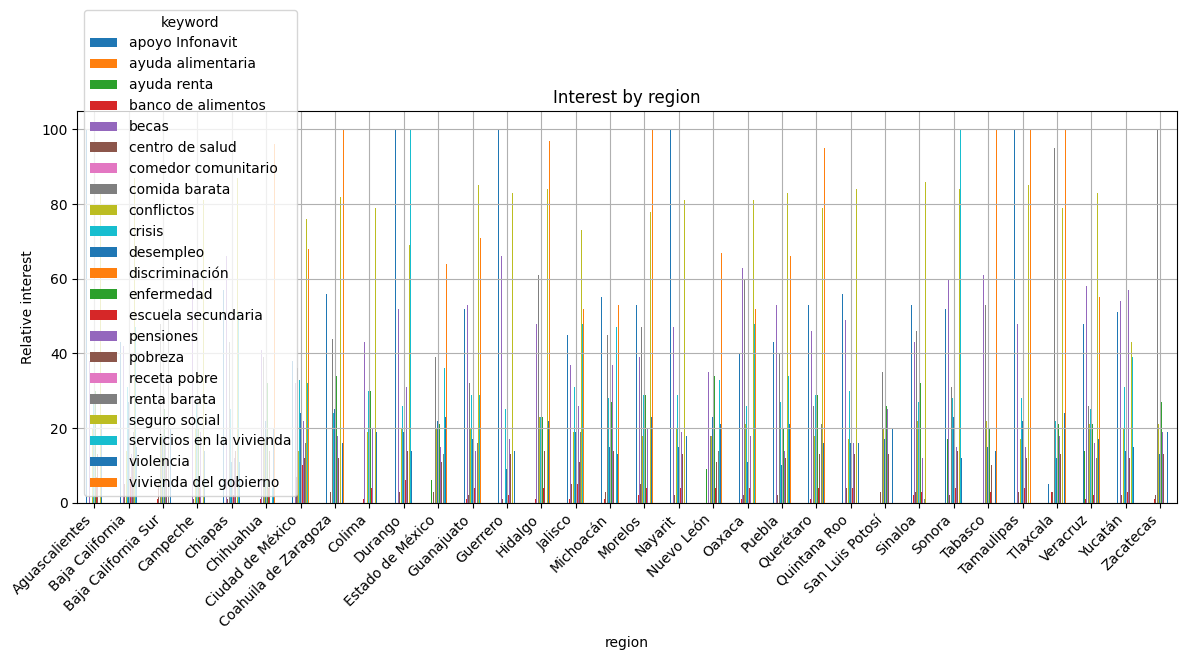

In [124]:
def plot_interest_by_region(data: dict):
    rows = []
    for kw, region_dict in data.items():
        for region, val in region_dict.items():
            rows.append({"keyword": kw, "region": region, "value": val})

    data = pd.DataFrame(rows)

    pivot = (data
            .pivot(index="region", columns="keyword", values="value")
            .fillna(0))

    pivot.plot(kind="bar", figsize=(12, 6))
    plt.grid(True)
    plt.ylabel("Relative interest")
    plt.xticks(rotation=45, ha="right")
    plt.title("Interest by region")
    plt.tight_layout()
    plt.show()

plot_interest_by_region(data)

In [125]:
def plot_one_keyword(data: dict, keyword: str) -> None:
    rows = []
    for kw, region_dict in data.items():
        for region, val in region_dict.items():
            rows.append({"keyword": kw, "region": region, "value": val})

    data = pd.DataFrame(rows)

    d = (
        data[data["keyword"] == keyword]
        .sort_values("value", ascending=False)
    )

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(d["region"], d["value"], color="pink", alpha=0.5)

    for bar in bars:
        width = bar.get_width()
        ax.text(
            width + 0.4,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.0f}",
            va="center",
            fontsize=9,
        )

    ax.invert_yaxis() 
    ax.set_xlabel("Relative interest")
    ax.set_title(f'{keyword} interest by region')

    ax.grid(True)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xlim(0, d["value"].max() * 1.15)

    plt.tight_layout()
    plt.show()


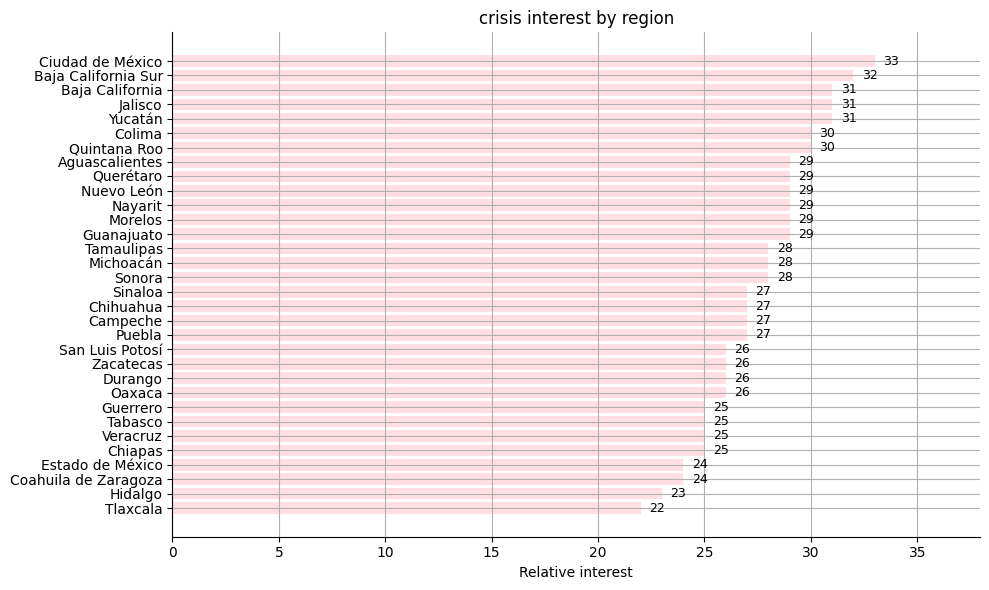

In [126]:
plot_one_keyword(data, "crisis")

In [127]:
mx_states = gpd.read_file("files/states.geojson")

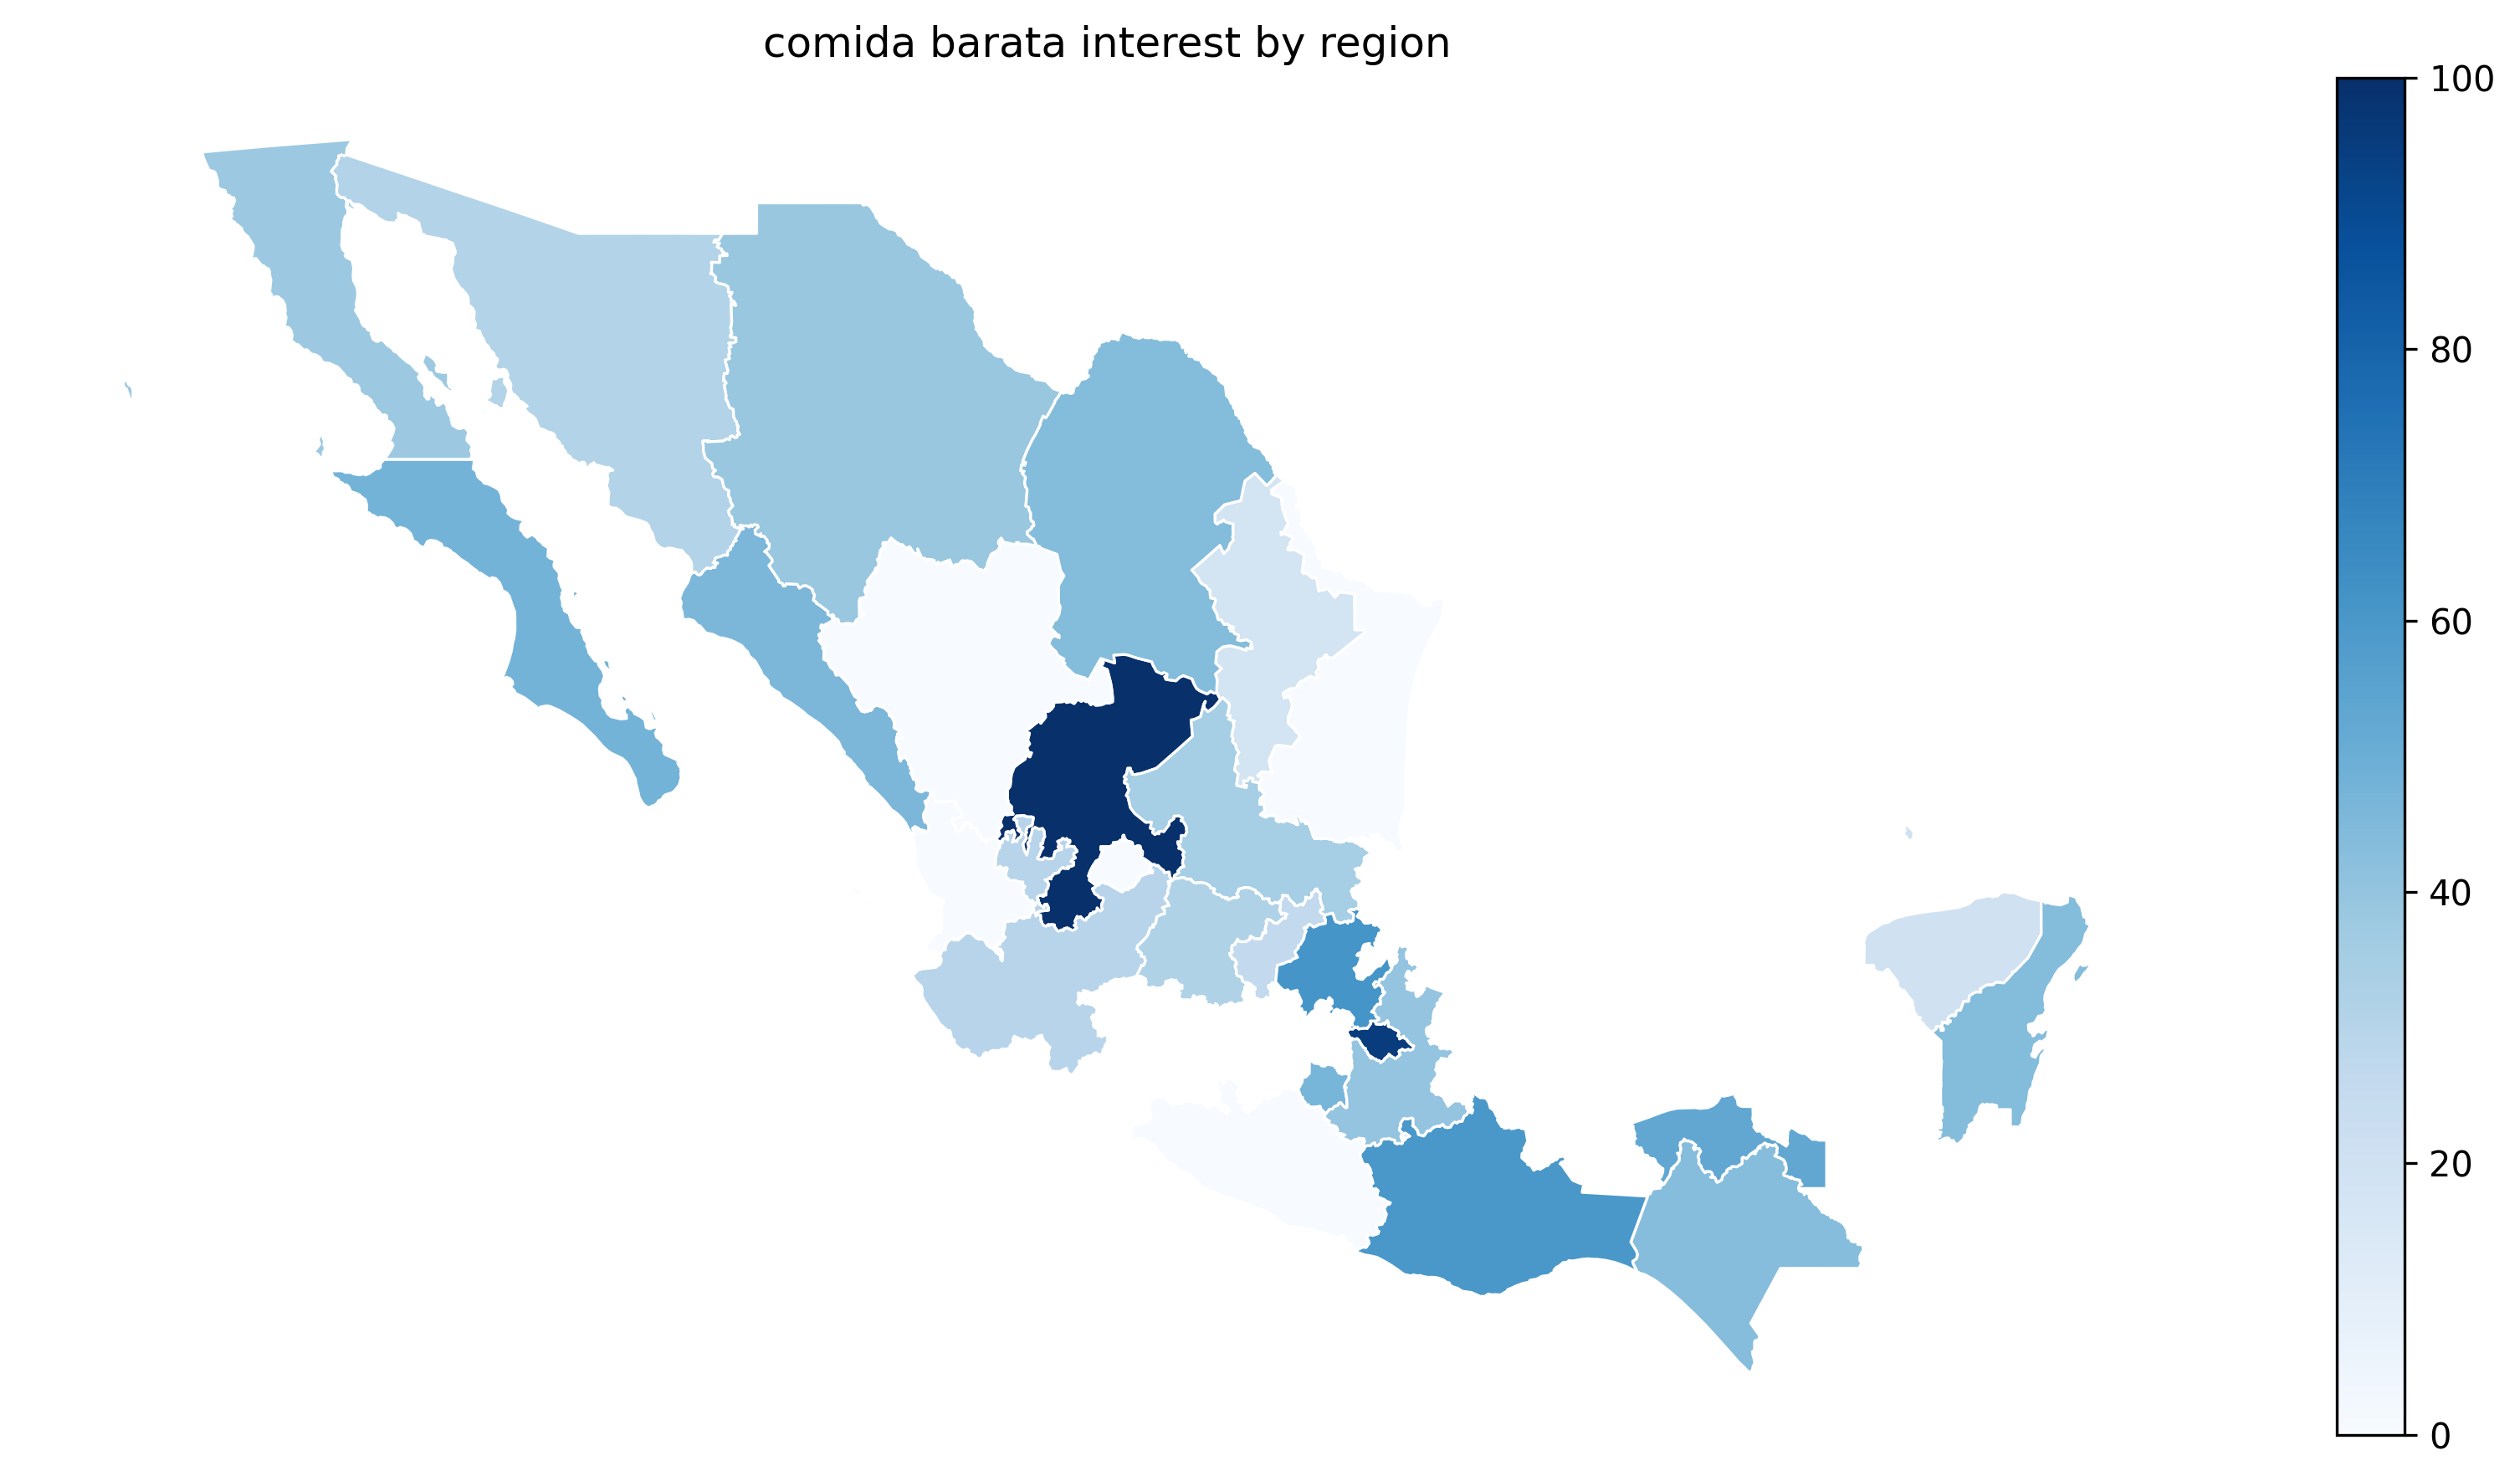

In [133]:
def plot_map(data: dict, keyword: str) -> None:
    rows = [
        {"region": r, "value": v}
        for r, v in data[keyword].items()
    ]
    data = pd.DataFrame(rows)

    mx_states_merged = mx_states.merge(
        data,
        left_on="state_name",
        right_on="region",
        how="left"
    )

    _, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)
    mx_states_merged.plot(
        column="value",
        cmap="Blues",
        linewidth=0.8,
        edgecolor="white",
        legend=True,
        ax=ax,
    )
    ax.set_axis_off()
    ax.set_title(f'{keyword} interest by region')
    plt.tight_layout()
    plt.show()

plot_map(data, "comida barata")